In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn import metrics

In [2]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Correlation map

<Axes: >

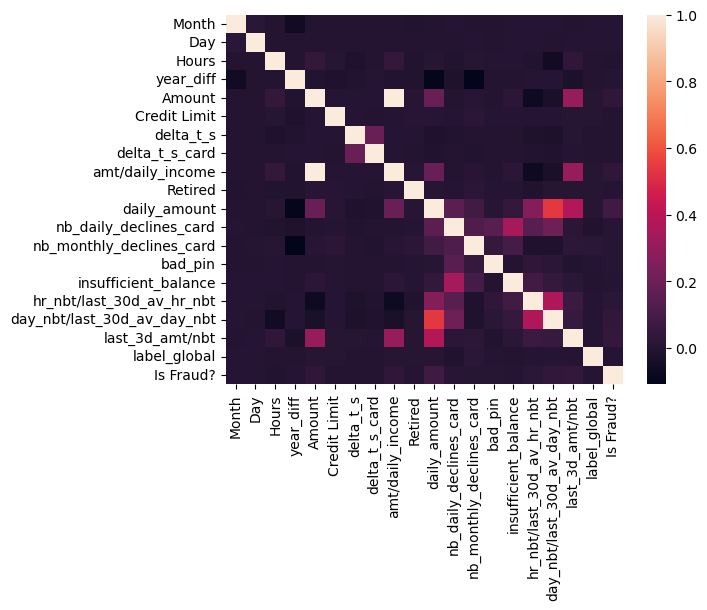

In [5]:
sns.heatmap(df_cct[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?']].corr())

In [3]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?'],
      dtype='object')

### Preprocessing (code to create standarized (by User) dataset) - DO NOT RUN

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df_cct.loc[:,~df_cct.columns.isin(["User","Card","label_global","Retired", "bad_pin", "insufficient_balance","Is Fraud?"])].select_dtypes(include=numerics).columns.to_list()
cat = df_cct.select_dtypes(include=['object']).columns.to_list()


In [5]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df = pd.DataFrame()
for i in range(2000):
    user_i = df_cct[df_cct["User"] == i]
    user_i[num] = scaler.fit_transform(user_i[num])
    df = pd.concat([df,user_i], axis=0)


/tmp/ipykernel_30315/3353035098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_i[num] = scaler.fit_transform(user_i[num])
/tmp/ipykernel_30315/3353035098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_i[num] = scaler.fit_transform(user_i[num])
/tmp/ipykernel_30315/3353035098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

KeyboardInterrupt: 

In [51]:
#df.to_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Encode categorical variables

In [6]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [7]:
# Pour "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [8]:
# Pour "Card Type"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [6]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Credit',
       'Debit', 'Debit (Prepaid)'],
      dtype='object')

### Manually create train/test datasets

In [9]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',
        "label_global","Is Fraud?"]
df_selec = df_cct[features] # 21 features

In [10]:
import random # manually creating train dataset (which is 50% of the whole dataset)
# random sampling among each cluster created from DBSCAN work
random.seed(42)
df_train = pd.DataFrame()
for i in range(-1,7,1):
    cluster_i_list = df_selec[df_selec["label_global"] == i].index.tolist()
    index = random.sample(cluster_i_list, int(len(df_selec[df_selec["label_global"] == i])*0.5))
    df_rs = df_selec.loc[index]
    df_train = pd.concat([df_train, df_rs], axis = 0)

In [11]:
#X_train, y_train, contains around 15,000 frauds
X_train = df_train.drop(["label_global","Is Fraud?"], axis = 1)
y_train = df_train["Is Fraud?"]

In [12]:
# retrieving frauds for later use
i_fraud = y_train[y_train.values == 1].index
X_train_fraud = X_train.loc[i_fraud]
i_no_fraud = y_train[y_train.values == 0].index
X_train_no_fraud = X_train.loc[i_no_fraud]

In [13]:
# test set : 55,000 rows, contains 5,000 frauds
df_rest = df_selec[~df_selec.index.isin(df_train.index)] # selecting the resting rows not taken for train set
df_rest_fraud = df_rest[df_rest["Is Fraud?"] == 1]
df_rest_no_fraud = df_rest[df_rest["Is Fraud?"] == 0]
df_test = pd.concat([df_rest_fraud.sample(5000, random_state = 42), df_rest_no_fraud.sample(50000, random_state = 42)], axis = 0)
df_test.sort_index(inplace=True)

In [14]:
X_test = df_test.drop(["label_global", "Is Fraud?"], axis = 1)
y_test = df_test["Is Fraud?"]

### Base - first model

In [24]:
# Build and train model without any hyperparameters
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
# Apply model to validation data
y_pred = decision_tree.predict(X_test)

Classification metrics: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     50000
           1       0.93      0.17      0.29      5000

    accuracy                           0.92     55000
   macro avg       0.92      0.58      0.62     55000
weighted avg       0.92      0.92      0.90     55000



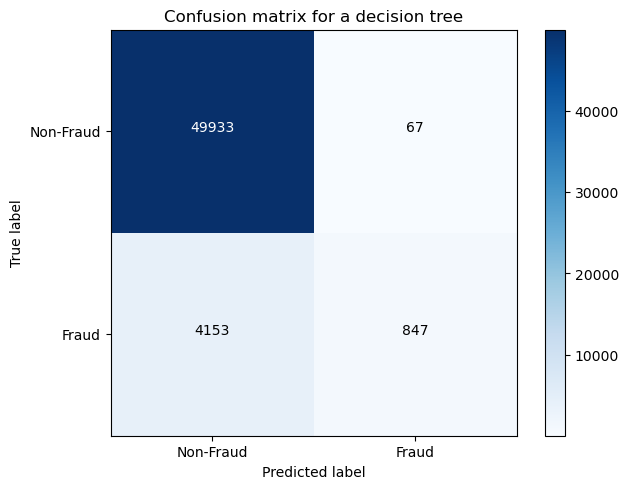

In [25]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred))
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()


cnf_matrix_dtree = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()

### SHAP values

In [25]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(decision_tree)

In [16]:
# selecting 15,000 frauds and 15,000 non frauds from train set
# otherwise, computation time is too big

X_train_shap = pd.concat([X_train_fraud, X_train_no_fraud.sample(len(X_train_fraud), random_state = 42)], axis = 0)

In [26]:
shap_values = explainer.shap_values(X_train_shap)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


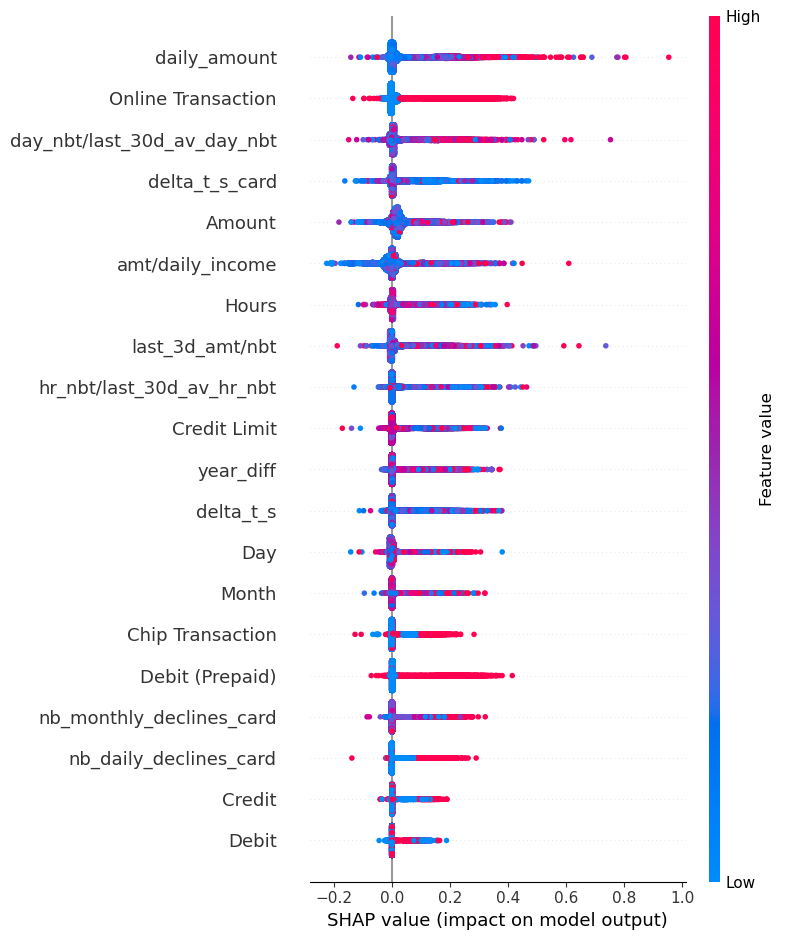

In [29]:
shap.summary_plot(shap_values[1], X_train_shap)

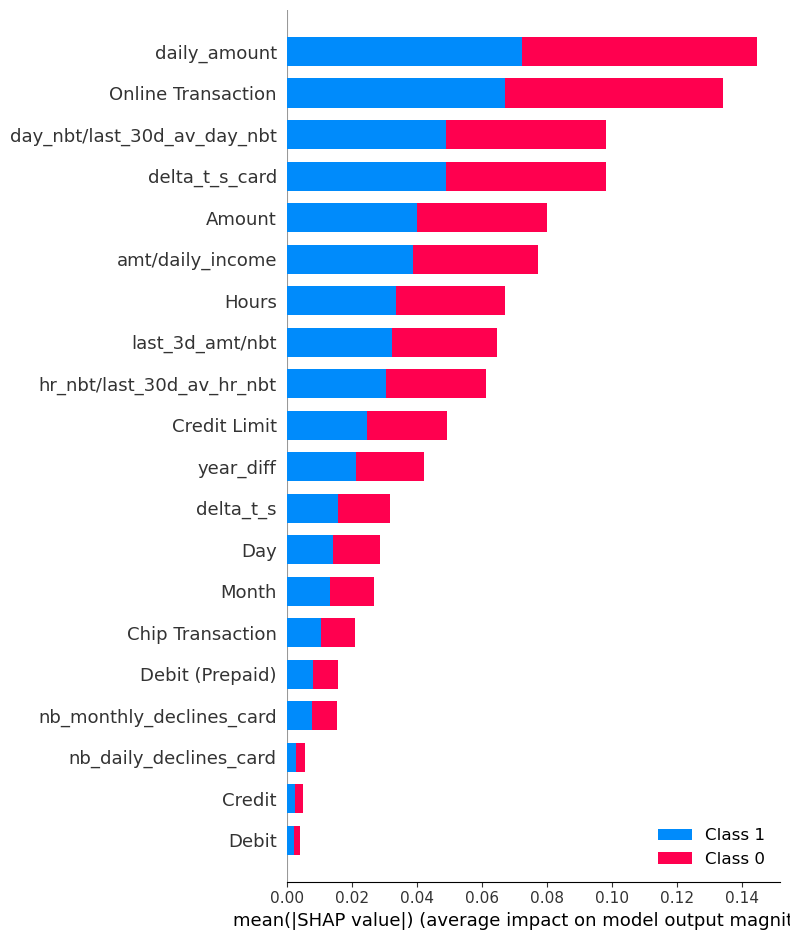

In [27]:
shap.summary_plot(shap_values, X_train_shap ,feature_names = X_train_shap.columns, plot_type="bar") 
# we can drop the 7 last ones : mastercard, amex, visa, discover, debit, credit, nb_daily_declines_card

### Tuning Hyperparameters

In [15]:
df_f1_score = pd.DataFrame(columns = ["min_samples_leaf", "f1score"])
for i in range(1, 200, 20):
    dt = DecisionTreeClassifier(min_samples_leaf=i)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score.loc[len(df_f1_score)] = [i, score]
df_f1_score    

,min_samples_leaf,f1score
0,1.0,0.282281
1,21.0,0.160662
2,41.0,0.144686
3,61.0,0.122020
4,81.0,0.112809
5,101.0,0.088286
6,121.0,0.091204
7,141.0,0.091932
8,161.0,0.100987
9,181.0,0.089016


Text(0.5, 1.0, 'f1-score according to min_samples_leaf (decision tree)')

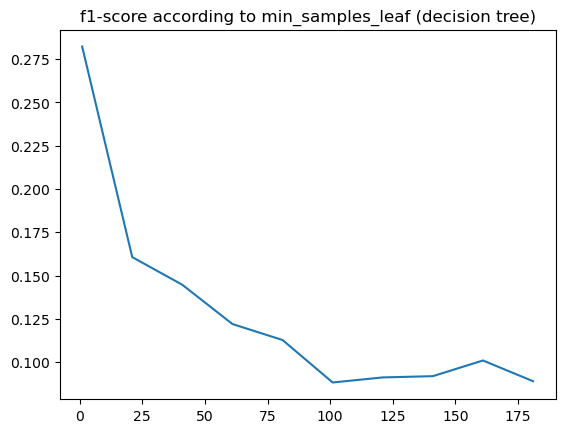

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score.iloc[:,0].values, df_f1_score.iloc[:,1].values)
plt.title('f1-score according to min_samples_leaf (decision tree)')

In [17]:
df_f1_score2 = pd.DataFrame(columns = ["max_depth", "f1score"])
for i in range(1, 50, 5):
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score2.loc[len(df_f1_score2)] = [i, score]
df_f1_score2

,max_depth,f1score
0,1.0,0.000000
1,6.0,0.057487
2,11.0,0.137777
3,16.0,0.214935
4,21.0,0.251349
5,26.0,0.281522
6,31.0,0.280469
7,36.0,0.277164
8,41.0,0.289043
9,46.0,0.287257


In [16]:
#import pandas as pd
#import numpy as np
#i = [i for i in range(1, 50, 5)]
#score = [0.000000, 0.057487, 0.137777, 0.214935, 0.251349, 0.281522, 0.280469, 0.277164, 0.289043, 0.287257]
#df_f1_score2 = pd.DataFrame({"max_depth" : i, "f1score" : score})



Text(0.5, 1.0, 'f1-score according to max_depth (decision tree)')

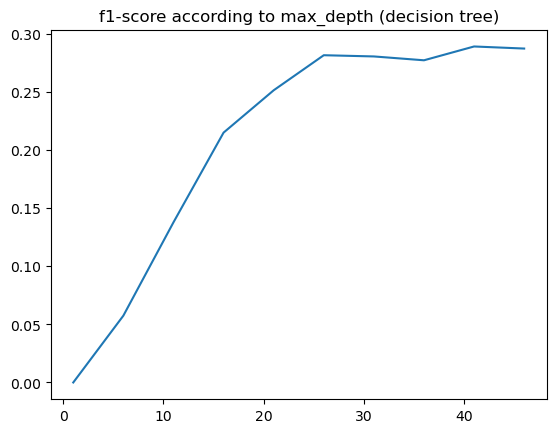

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score2.iloc[:,0].values, df_f1_score2.iloc[:,1].values)
plt.title('f1-score according to max_depth (decision tree)')

In [ ]:
df_f1_score3 = pd.DataFrame(columns = ["max_features", "f1score"])
for i in range(1, 50, 5):
    dt = DecisionTreeClassifier(max_features=i)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score2.loc[len(df_f1_score2)] = [i, score]
df_f1_score2

### Evaluating

In [35]:
# Build and train model
decision_tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth = 30)
decision_tree.fit(X_train, y_train)
# Apply model to validation data
y_pred = decision_tree.predict(X_test)

In [36]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    480000
           1       0.84      0.16      0.26     17913

    accuracy                           0.97    497913
   macro avg       0.90      0.58      0.62    497913
weighted avg       0.96      0.97      0.96    497913



In [26]:
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()

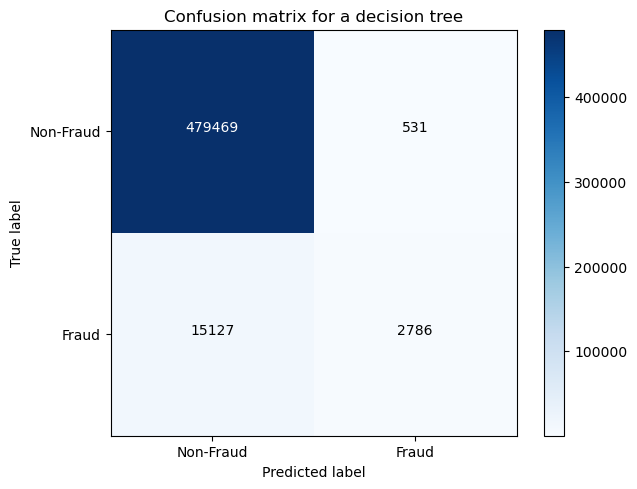

In [37]:

cnf_matrix_dtree = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
cost = fp*15 + fn*45 - tp*45
cost

424275

### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(min_samples_leaf=10)
rforest.fit(X_train,y_train)

RandomForestClassifier(max_depth=20)

In [31]:
y_pred_rf = rforest.predict(X_test)

In [32]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred_rf))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    480000
           1       0.99      0.06      0.10     17913

    accuracy                           0.97    497913
   macro avg       0.98      0.53      0.54    497913
weighted avg       0.97      0.97      0.95    497913



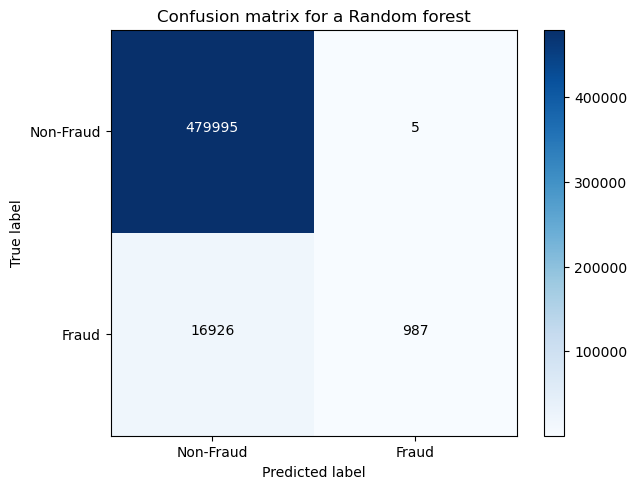

In [33]:
cnf_matrix_dtree = confusion_matrix(y_test, y_pred_rf)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a Random forest')
plt.show()